In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# import constraint Learning Tool 
import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl
import torch
from src.visualize import plot_two_turbine_results

from sklearn.model_selection import train_test_split

import itertools
import numpy as np

from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")

In [3]:
### Test/Train Split
# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

# Define model
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],
                    y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)


# optimize NN

In [4]:
# param_grid = {
#     'n_hidden': [2, 3, 4],
#     'n_nodes': [6, 8, 10]
# }

# best_params, best_rmse, grid_search = cl_tool.optimize_nn(param_grid = param_grid,iters = 2500,plot = True)

In [5]:
# # Retrain the model with the best parameters
# model, preds_test, y_test = cl_tool.train(n_hidden=10, n_nodes=25 , iters=5000, drop=0.05, learning_rate=1e-3)

# torch.save(model, "models/prob_10lay_25node.pth")

# Analytics (Deterministic)

In [6]:
model = cl_tool.load_model(path="models/prob_10lay_25node.pth")

In [7]:
data["farm_power_pred"] = cl_tool.predict(X = data[["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"]])
data["error"] = data["farm_power_pred"] - data["farm_power"]
data["error_percent"] = data["error"] / data["farm_power"] * 100

In [8]:
degree = 260

# Define the ranges for each feature
x_turb2_range = np.arange(0, 5001, 10) 
y_turb2_range = np.arange(0, 601, 10)
wind_speed_range = [8] #np.arange(6.0, 13.0, 2.0)
wind_direction_range = [degree] #np.arange(0, 361, 90)
turbulence_intensity = [0.06]

# Generate all possible combinations
combinations = list(itertools.product(
    x_turb2_range,
    y_turb2_range,
    wind_speed_range,
    wind_direction_range,
    turbulence_intensity
))
generated_data = pd.DataFrame(combinations, columns=["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"])

# predict
generated_data['pred'] = cl_tool.predict(X = generated_data[["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"]])

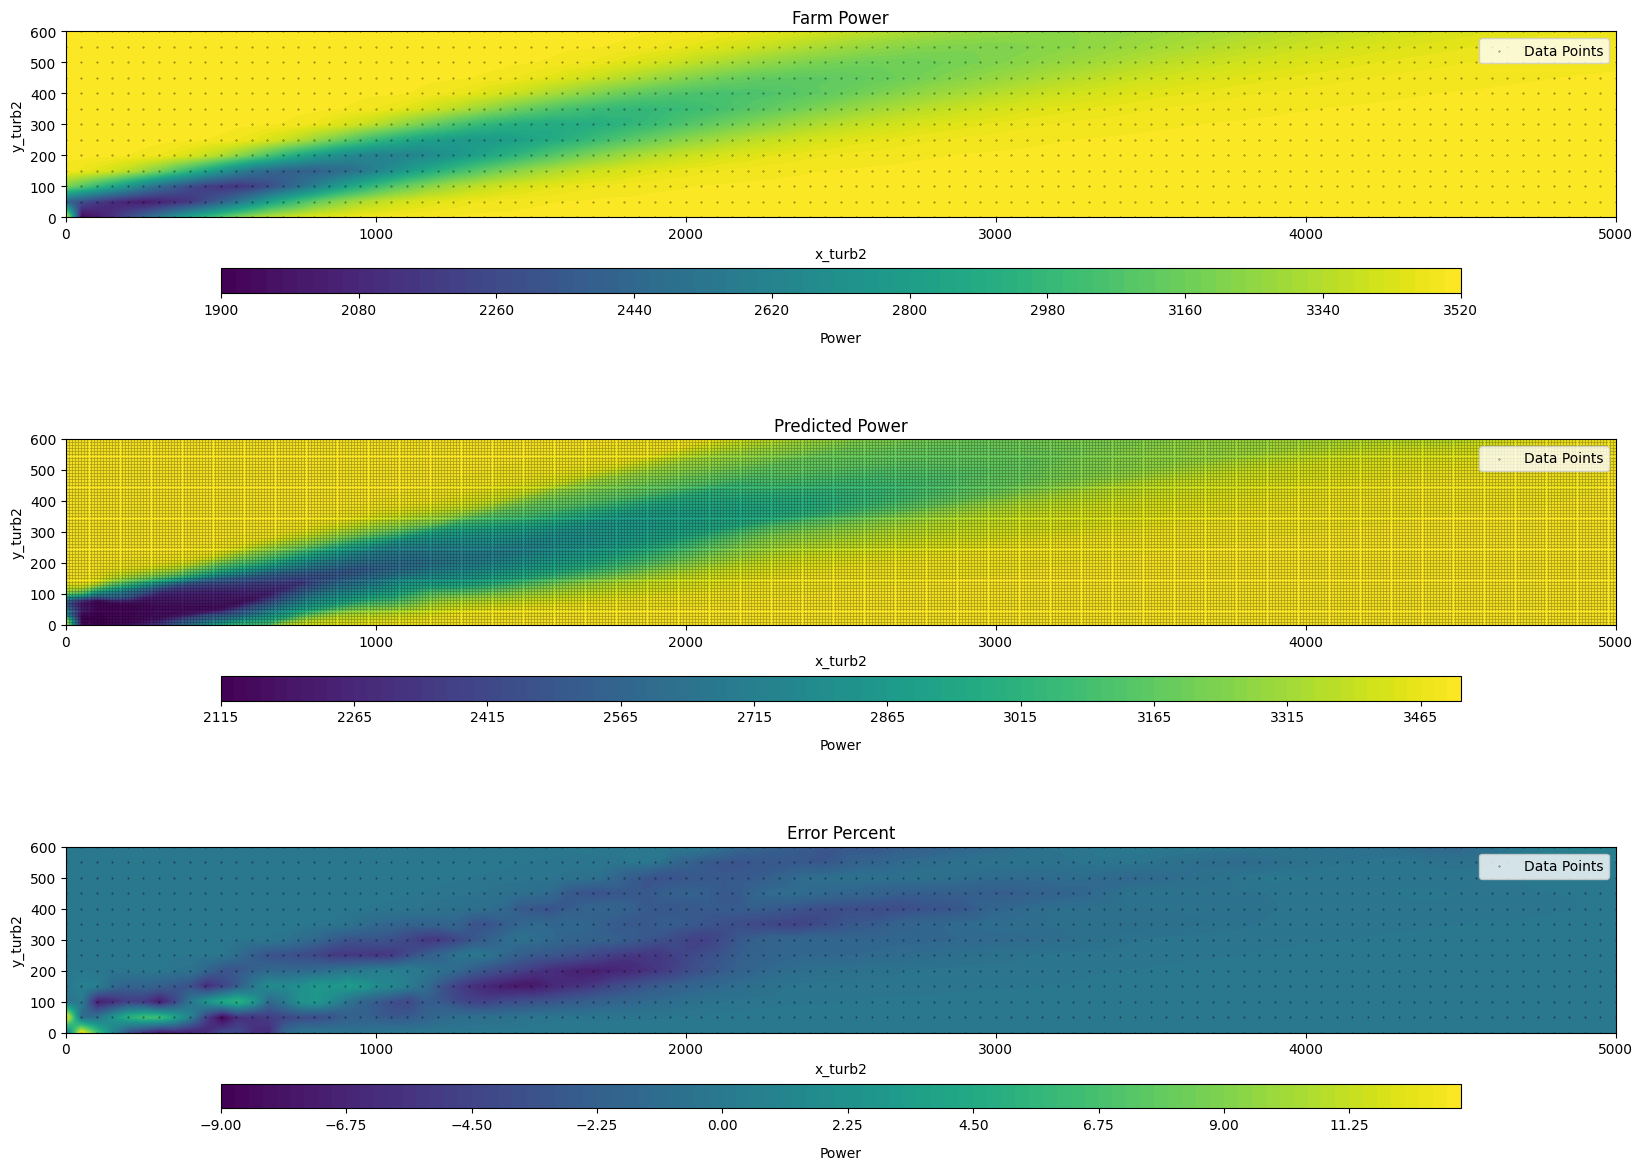

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

# Plot farm_power
plot_two_turbine_results(data[data["wind_direction"] == degree], zfeature="farm_power", dpoint_size=0.1, ax=axes[0])
axes[0].set_title("Farm Power")

# Plot pred
plot_two_turbine_results(generated_data, zfeature="pred", dpoint_size=0.1, ax=axes[1])
axes[1].set_title("Predicted Power")

# Plot error_percent
plot_two_turbine_results(data[data["wind_direction"] == degree], zfeature="error_percent", dpoint_size=0.1, ax=axes[2])
axes[2].set_title("Error Percent")

plt.show()

# Analytics (Probabilistic)

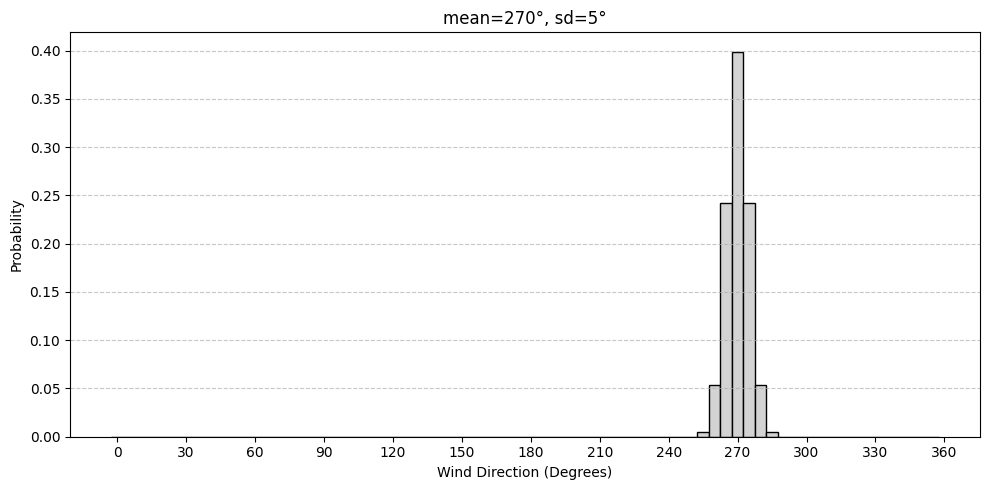

In [10]:
# Generate wind direction distribution
from src.simulate_data import generate_wind_direction_distribution
wind_df = generate_wind_direction_distribution(mu=270, sd=5, wind_speed=8, turbulence_intensity=0.06, step=5)


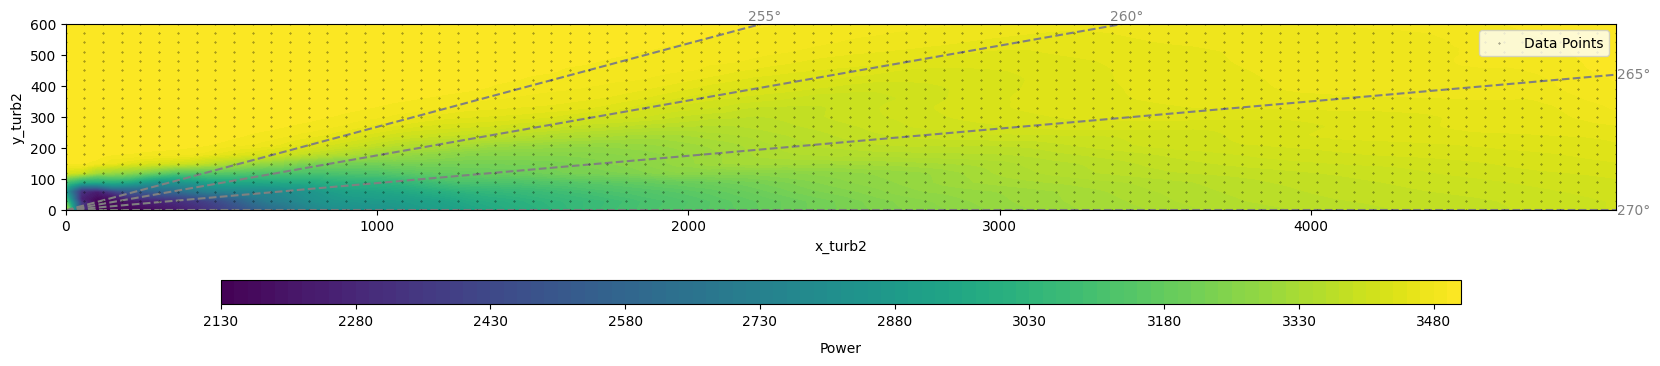

In [11]:
# Generate Data
x_turb2_range = np.arange(0, 5001, 60)
y_turb2_range = np.arange(0, 601, 30)

results = []
for x_val in x_turb2_range:
    for y_val in y_turb2_range:
        # predict expected power
        exp_power = cl_tool.expected_power_for_location(x_val, y_val, wind_df)
        results.append({'x_turb2': x_val, 'y_turb2': y_val, 'expected_power': exp_power})

expected_power_grid = pd.DataFrame(results)

# plot
plot_two_turbine_results(expected_power_grid, zfeature="expected_power", dpoint_size=0.1,wind_df=wind_df, model_opt=None)


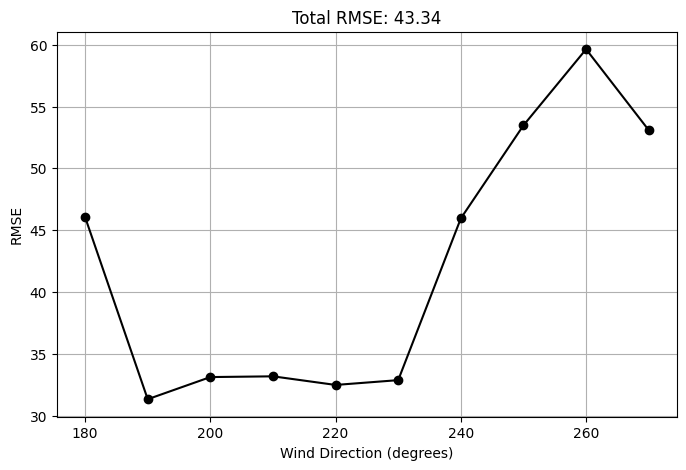

In [12]:
wind_dirs = np.arange(180, 271, 10)
rmse_results = []
all_actual = []
all_pred = []


for wd in wind_dirs:
    # Filter data for the current wind direction
    df_actual = data[data["wind_direction"] == wd]
    preds = cl_tool.predict(X=df_actual[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]])
    # Align actual and predicted by index (assuming same grid)
    mse = mean_squared_error(df_actual["farm_power"], preds[:len(df_actual)])
    rmse = np.sqrt(mse)
    rmse_results.append(rmse)
    all_actual.append(df_actual["farm_power"].values)
    all_pred.append(preds[:len(df_actual)])

# Concatenate all actual and predicted values
all_actual_flat = np.concatenate(all_actual)
all_pred_flat = np.concatenate(all_pred)
total_rmse = np.sqrt(mean_squared_error(all_actual_flat, all_pred_flat))

plt.figure(figsize=(8, 5))
plt.plot(wind_dirs, rmse_results, marker='o', linestyle='-', color='black')
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("RMSE")
plt.title(f"Total RMSE: {total_rmse:.2f}")
plt.grid(True)
plt.show()
